# A. Importing standard libraries and user-defined libraries

In [5]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath

import a_matrix_analysis_lib as mat_ansys
import b_spin_representations as su2
import c_evs_visualization_tools as evs_visz_tools
import d_projected_evolution_dynamics as me
import e_Multiple_Max_Ent_evs as rme

from IPython.display import display, Math, Latex
np.set_printoptions(threshold=1.e-9,linewidth=120,precision=3, suppress=True, formatter={"float":lambda x: str(.001*int(1000*x))})

# B. Defining the system

## 1. Ferromagnetic XX-model's Hamiltonian

We start by considering a ferromagnetic XX-Heisenberg-like six-site lattice, with closed boundary conditions, acting on the system's Hilbert space,  $\bigotimes_{i=1}^{N=6}{\bf C}^2$.

In order to do that, we invoke *b_spin_representations'* s module "one_body_spin_ops" which constructs the appropiate local one-body Pauli operators acting on the full Hilbert's space, i.e.

$$
    {\bf S}_{{x,y,z}}^{j} = \textrm{id}_2 \otimes \cdots \otimes {\bf S}_{{x,y,z}}^{j} \otimes \cdots \otimes \textrm{id}_2
$$

where a total of $j-1$ identity operators act on the left, while a total of $N-j$ identity operators act on the right. 


In [6]:
N=6; chain_type = "XX"
spin_ops_list = su2.one_body_spin_ops(size = N) ### One body local spin operators
identity_op = spin_ops_list[0][0]

Hamiltonian_paras = [-1e-1, -2.5e-1, 0., .5e-1]
H_H = su2.Heisenberg_Hamiltonian(op_list = spin_ops_list, chain_type = chain_type,
                                           size = N, Hamiltonian_paras = Hamiltonian_paras,
                                           closed_bcs = True, visualization = False) 

## 2. Defining the set of classical operators

We define the set of classical operators, by invoking *{b_spin_representations}'* s module "classical_ops". A test is implemented to check that these are, in fact, physical observables, i.e. Hermitian operators.

In [7]:
cl_ops, label_ops = su2.classical_ops(size = N, Hamiltonian = H_H,
                                                op_list = spin_ops_list, centered_x_op = False)

magnetization = sum(spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))
neel_operator = sum((-1)**a * spin_ops_list[3][a] for a in range(len(spin_ops_list[3])))

cl_ops["magnetization"] = magnetization; label_ops.append("magnetization")
cl_ops["neel_op"] = neel_operator; label_ops.append("neel_op")
cl_ops["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; label_ops.append("n_oc_op_sq")
cl_ops["x_op"] = -.1 * (spin_ops_list[3][2] - spin_ops_list[3][0])

print("Are all the operators Hermitian?:", mat_ansys.basis_hermitian_check(basis = cl_ops))

Are all the operators Hermitian?: [True, True, True, True, True, True, True, True, True, True, True]


## 3. Observables of interest

A subset of physical observables, whose time evolution of its expectation value is of interest, is defined:

$$
    \{{\bf x}, {\bf n}, {\bf n}^2\}
$$

In [8]:
# solo algunos observables
subset_of_observables = {}; subset_label_ops = []
subset_of_observables["x_op_sq"] = cl_ops["x_op"]**2; subset_label_ops.append("x_op_sq")
subset_of_observables["n_oc_op"] = cl_ops["n_oc_op"]; subset_label_ops.append("n_oc_op")
subset_of_observables["n_oc_op_sq"] = cl_ops["n_oc_op"]**2; subset_label_ops.append("n_oc_op_sq")

# 4. Referential state

In the restricted Max-Ent evolution algorithm, the system's initial state is recursively defined in terms of a referential state $\sigma_{\textrm{ref}}$ and an orthogonalization procedure, which will be treated later on. 
This referential state can be obtained as a Max-Ent state with respect to a known basis of operators ${\cal B} = \{{\cal O}_{\alpha}\}^{\alpha}$, with some real-valued weights $(\lambda_{\alpha})^{\alpha} \in {\bf R}$.
Then, the referential state reads 

$$
    \sigma_{\textrm{ref}} = \exp \bigg( 
                                              - \beta_{\textrm{ref}} \sum_{\alpha} \lambda_{\alpha} {\cal O}_{\alpha}
                                                \bigg)
$$

s.t. $\sigma_{\textrm{ref}}$ has unitary trace. It is clear, from such construction, that $\sigma_{\textrm{ref}}$ is a well-defined density operator, lying on the system's phase space. 

In particular, we are interested in the following state,

$$
    \sigma_{\textrm{ref}} \propto e^{-  \beta_{\textrm{ref}} {\bf K}_{\textrm{ref}}}, 
    \textrm{ s.t. } {\bf K}_{\textrm{ref}} = c_1 {\bf H} + c_2 (\hat{{\bf n}} - \zeta)^2 + c_3 \hat{{\bf x}}
$$

with $c_1, c_2, c_3, \zeta$ chosen s.t. $\langle \hat{\bf n} \rangle_{\sigma_{\textrm{ref}}} \approx 1$. The previous state's logarithm, i.e. its ${{\bf K}_{\textrm{ref}}}$ operator, may be expanded in terms of the following ${\cal B}$-basis 

$$
    {\cal B} = \{\textrm{id}, {\bf H}, \hat{{\bf n}}, \hat{{\bf n}}^2, \hat{{\bf x}}\}
$$

In [9]:
#OLD
#c1 = 1; c2 = 1; c3 = 10; zeta = .5
#temp_ref = 1e0; temp = 1e0
#beta_ref = 1/temp_ref
#K_ref = K0 = c1 * H_H + c2 * (cl_ops["n_oc_op"] - zeta * identity_op)**2 + c3 * cl_ops["x_op"] 

#coeff_basis_t0 = [c2 * zeta**2 *beta_ref, c1*beta_ref, (-2)*c2*zeta*beta_ref, c2*beta_ref, c3*beta_ref]
#rho_ref = (-beta_ref * K_ref).expm()
#rho_ref = rho_ref/rho_ref.tr()

#calB_basis_0 = [identity_op, H_H, cl_ops["n_oc_op"], cl_ops["n_oc_op_sq"]] # with the last number corresponding to cl_ops["x_op"]

In [10]:
c1 = 0; c2 = 1.5; c3 = 0
temp_ref = 1e0; temp = 1e0
beta_ref = 1/temp_ref
K_ref = c1 * H_H + c2 * cl_ops["n_oc_op"] + c3 * cl_ops["x_op"] 
rho_ref = (-beta_ref * K_ref).expm()
rho_ref = rho_ref/rho_ref.tr()

# with the last number corresponding to cl_ops["x_op"]

In [11]:
qutip.expect(cl_ops["n_oc_op"], rho_ref)

1.0945531428381385

## 5. Setting up the restricted Max-Ent evolutions  

An important parameter of a restricted Max-Ent evolution is the dimension of its associated Hierarchical Basis.
A Hierarchical Basis is defined as follows,

$$
    \cal{B}^{\ell} = \cal{B}^{0} + \cal{B}^{1}, 
$$

where $\cal{B}^{0}=\{\textrm{id}, {\bf H}, \hat{{\bf n}}, \hat{{\bf n}}^2, \hat{{\bf x}}\} $ and where $\cal{B}^{1}$ includes a total of $\ell$ iterated commutators, with respect to a fixed, known, and physically relevant, seed operator, ${\bf A}$, i.e.

$$
    \cal{B}^{1} = \{\textrm{[}{\bf H}, {\bf A}\textrm{]}, \textrm{[}{\bf H},\textrm{[}{\bf H},{\bf A}\textrm{]}\textrm{]} \cdots\}
$$

The complete set $\cal{B}^{\ell}$ is then a $(\ell + 4)$-dimensional basis on a subspace $\bar{\cal B}^{\ell}$ of Hermitian operators ${\bf K}$. Exponentiation of these ${\bf K}$ operators gives rise to a subspace of density matrices, ${\cal V}^{\ell}$, i.e. 

$$
    {\cal V}^{\ell} = \{ \sigma : \sigma \propto e^{-{\bf K}} \textrm{ with } {\bf K} = \sum_{\alpha} \lambda_{\alpha} \bar{\bf O}_{\alpha}  \}
$$

The main advantage of this construction is that the evolution is closed on each ${\cal V}^{\ell}$ subspace. 
Here, we specify how many commutators are to be included in each restricted Max-Ent evolution.

In particular, we have chosen to compute three, separate, restricted evolutions for three different Hierarchical bases, with one, three and six iterated commutators, respectively. 
Moreover, we also specify the initial configuration of numbers $\{\lambda_{\alpha}(0)\}^\alpha$, characterizing the initial state's expansion in terms of the basis $\cal{B}^{\ell}$

# C. Exact and restricted Max-Ent evolutions for the XX chain

Here, we carry out the exact and the three restricted Max-Ent evolutions. 

## 1. Time grid
We start by specifying the desired times, for which observables and states for each evolution is desired.

In [13]:
ts = np.linspace(0, 5., 500)

## 2. Computing the evolutions

An in-depth explanation of the details of the restricted Max-Ent evolutions can be found in the article itself and in the documentation of the modules used here, we give a very brief rundown on how the algorithm works. 

### 2.1 Restricted Max-Ent's States

Consider a Hierarchical Basis ${\cal B}^{\ell}$ and a referential state $\sigma_{\textrm{ref}}$, such as the one considered previously. The previous basis can be orthonormalized with respect to this referential state, by using a real-valued Hilbert-Schmidt-like inner product, yielding an orthonormal basis $\bar{\cal B}^{\ell}$, which reads 

$$
    ({\bf O}, {\bf Q})^{\sigma_{\textrm{ref}}}_{\textrm{HS}} = \frac{1}{2} \textrm{Tr} \sigma_{\textrm{ref}} \{{\bf O}^\dagger, {\bf Q}\}.
$$

Then, the equation of motion on the density states can be mapped to an equation of motion on the correlations themselves, which reads 

$$
    \frac{d \lambda_{\alpha}(t)}{dt} = \sum_{\beta}\frac{\hbar}{i} (e^{i {\cal H} t})_{\alpha \beta} \lambda_{\beta}(t),
$$

where ${\cal H}$ is a special tensor, acting on the orthonormalized Hierarchical bases $\bar{\cal B}^{\ell}$, given by 

$$
    {\cal H}_{\alpha \beta} = ( \bar{\bf O}_{\alpha}, [{\bf H}, \bar{\bf O}_{\beta}] )_{\textrm{HS}}^{\sigma_{\textrm{ref}}}
$$

The restricted Max-Ent $\sigma$ states are obtained from solving the previous differential equation. Said differential equation' s formal solution is given by left-action of the kernel $K(t,t') = e^{i {\cal H} (t-t')}$ on an initial configuration $\{\lambda_{\alpha}(0)\}^{\alpha}$ and where ${\cal H}$ is the previously defined tensor, acting on the space of Hermitian operators. 

In particular this initial configuration of real valued numbers gives rise to the system's initial state $\rho_0$ via exponentiation, which is not relevant to the Max-Ent evolutions, but to the exact evolution. 

The solutions of this differential equation, $\{\lambda_{\alpha}(t)\}^{\alpha}$, then give rise to Hermitian operators, as follows

$$
    {\bf K}(t) = \sum_{\alpha} \lambda_{\alpha}(t) \bar{{\bf O}}_{\alpha},
$$

from which the approximate density states, $\sigma$ are obtained, as follows,

$$
    \sigma(t) = {\exp (-{\bf K}(t) )}.
$$

### 2.2 Numerical Computations

Now, we invoke *e_Multiple_Max_Ent_evs*'s module, "multiple_MaxEnt_evs", to perform and compute several quantities of interest, e.g. 

* the exact and approximate expected value of the observables chosen in B.3
* the exact density states, $\rho$, and the restricted Max-Ent states, $\sigma$, for each chosen approximate evolution. 

In [14]:
c1 = 1; c2 = 1; c3 = 5; zeta = .25
temp_ref = 1e0; temp = 1e0
beta = 1/temp
K0 = c1 * H_H + c2 * (cl_ops["n_oc_op"] - zeta * identity_op)**2 + c3 * cl_ops["x_op"] 

coeff_basis_t0 = [c2 * zeta**2 *beta, c1*beta, (-2)*c2*zeta*beta, c2*beta, c3*beta]
K1 = K0 - max(K0.eigenenergies())
rho0 = (-beta * K1).expm()
rho0 = rho0/rho0.tr()

calB_basis_0 = [identity_op, H_H, cl_ops["n_oc_op"], cl_ops["n_oc_op"]**2]  # with the last number corresponding to cl_ops["x_op"]
assert mat_ansys.is_density_op(rho0), "rho0 is not density state"
qutip.expect(cl_ops["n_oc_op"], rho0)

(1.0180189128873425+0j)

In [15]:
range_derived_series_orders = depth_parameters = [0, 1, 2, 3, 4, 5, 6, 7, 8]
all_coeff_list = [coeff_basis_t0 + list(np.zeros(a)) for a in depth_parameters]
print(all_coeff_list[0])
print(all_coeff_list[1])
print(all_coeff_list[2])

[0.0625, 1.0, -0.5, 1.0, 5.0]
[0.0625, 1.0, -0.5, 1.0, 5.0, 0.0]
[0.0625, 1.0, -0.5, 1.0, 5.0, 0.0, 0.0]


Processing step:  1  and hierarchical basis of ℓ=  0
    |▼| 1. Processing reference state ===>
              c. ^^##^^. custom reference state chosen
    |▼| 2. Constructing Hierarchical Basis of total dimension  5
    |▼| 3. Orthonormal Hierarchical Basis of size  5
        ||♧|| Test 1. Check on the orthonormality of the HB
          -. Check passed: the basis is orthonormal and hermitian
    |▼| 4. Constructing Initial Density State
            c. ^^##^^. custom Init state chosen
        ||♧|| Test 2. Check on the lengths of the orth. HB and the initial config phi0
            -b. ^^##^^. Check passed: phi0 and orth. HB have the same cardinalities.
    |▼| 5. Constructing H-tensor from orth. HB
    |▼| 6. ProjEv Dynamics Succesfully Concluded.
    |▼| 7b. Exact Dynamics not to be computed. Skipped.
    |▼| 7b. No Plots to process.
    |▼| 8. Data Stored. Evolutions concluded. 

Processing step:  2  and hierarchical basis of ℓ=  1
    |▼| 1. Processing reference state ===>
         

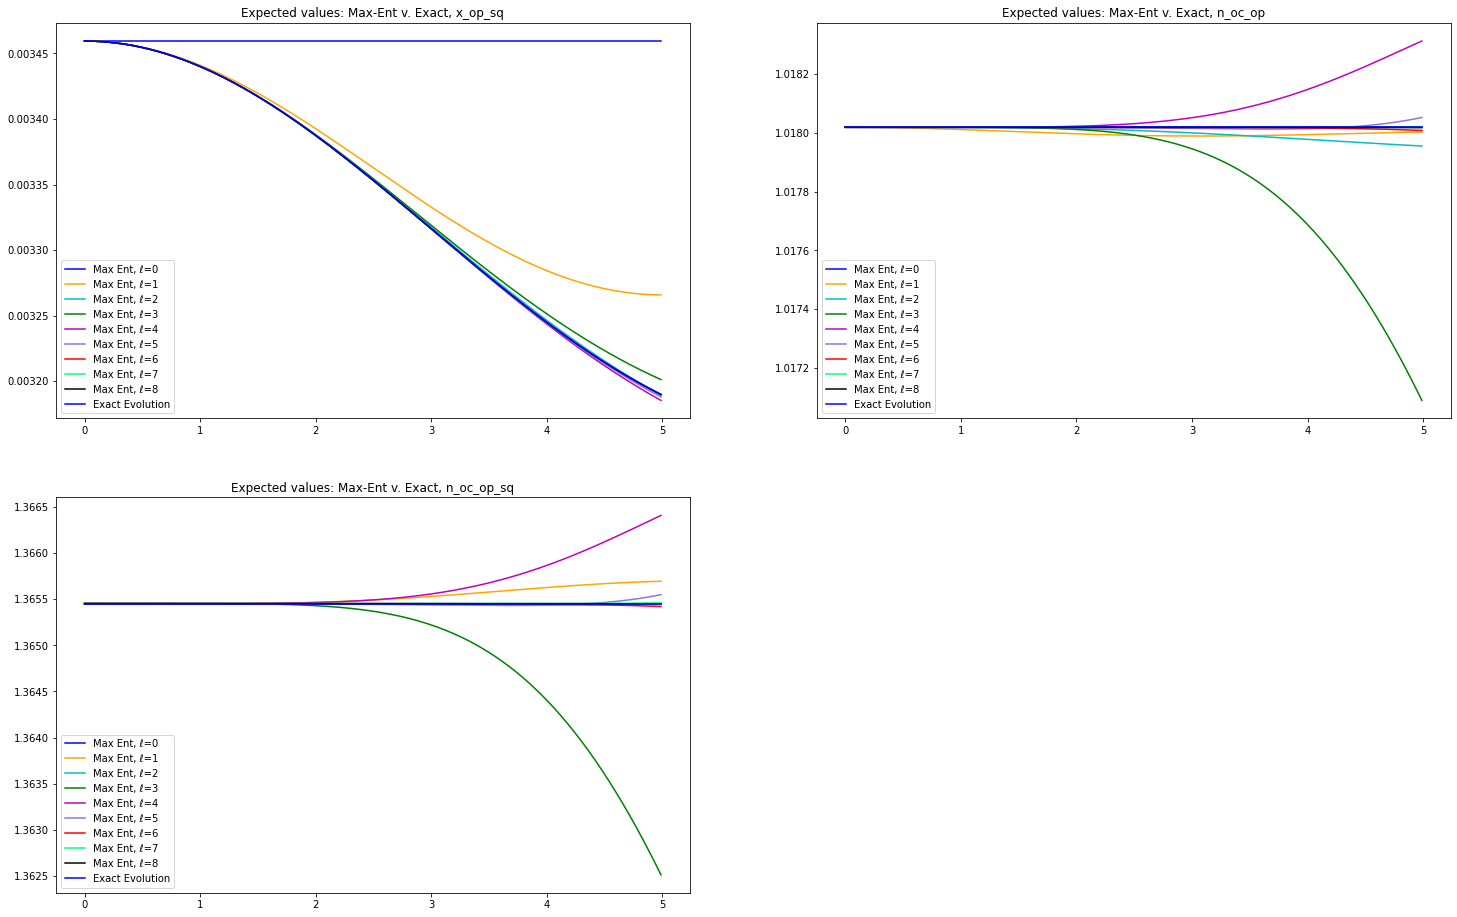

In [16]:
ts = np.linspace(0, 5, 500)

colours = ["blue", "orange", "c","g", "m", "mediumpurple", "r", "springgreen", "black"]

resultados = rme.multiple_MaxEnt_evs(Hamiltonian = H_H, fixed_ops_list = calB_basis_0, range_HierarchBases_dims = depth_parameters,
                                          temp_ref = temp_ref, temp_rho = temp,
                                          rho0 = rho0, K0 = K0, custom_ref_state = rho_ref, Kref = K_ref, coeff_list = coeff_basis_t0,
                                          generating_operator = cl_ops["x_op"],
                                                     init_coeff_list = all_coeff_list, 
                                                     timespan = ts, label_ops = subset_label_ops,
                                                     observables = list(subset_of_observables.values()),
                                                     rho_ref_equal_rho0 = False)

evs_visz_tools.plot_exact_v_proj_ev_avgs_multiple(labels = subset_label_ops,
                         timespan = ts,
                         list_of_colors = colours,                         
                         no_cols_desired = 2,
                         multiple_evolutions = resultados,
                         range_of_temps_or_dims = range_derived_series_orders,
                                          plot_var_HierarchBases_dim = True)

In [17]:
phi0_3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["Coeff_ev"][0]
phi0_6 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Coeff_ev"][0]
for i in phi0_3:
    print(i.real)
    
for i in phi0_6:
    if i > 1e-5:
        print(i.real)
    else:
        print(0)    

1.857571133844168
-0.8383971559151209
1.9103422622967736
1.1552834500286455
0.27308098805146874
0.0
4.85722573273506e-17
0.0
1.857571133844168
0
1.9103422622967736
1.1552834500286455
0.27308098805146874
0
0
0
0
0
0


In [18]:
rho_ref0 = resultados["all_init_configs"]["init_configs_MaxEnt0"]["rho_ref"]
rho_ref1 = resultados["all_init_configs"]["init_configs_MaxEnt1"]["rho_ref"]
rho_ref2 = resultados["all_init_configs"]["init_configs_MaxEnt2"]["rho_ref"]
rho_ref3 = resultados["all_init_configs"]["init_configs_MaxEnt3"]["rho_ref"]
rho_ref4 = resultados["all_init_configs"]["init_configs_MaxEnt4"]["rho_ref"]
rho_ref5 = resultados["all_init_configs"]["init_configs_MaxEnt5"]["rho_ref"]
rho_ref6 = resultados["all_init_configs"]["init_configs_MaxEnt6"]["rho_ref"]
rho_ref7 = resultados["all_init_configs"]["init_configs_MaxEnt7"]["rho_ref"]
rho_ref8 = resultados["all_init_configs"]["init_configs_MaxEnt8"]["rho_ref"]

rho_ref0 == rho_ref1 == rho_ref2 == rho_ref3 == rho_ref4 == rho_ref5 == rho_ref6 == rho_ref7 == rho_ref8

True

In [19]:
rho0_ell0 = resultados["all_init_configs"]["init_configs_MaxEnt0"]["rho0"]
rho0_ell1 = resultados["all_init_configs"]["init_configs_MaxEnt1"]["rho0"]
rho0_ell2 = resultados["all_init_configs"]["init_configs_MaxEnt2"]["rho0"]
rho0_ell3 = resultados["all_init_configs"]["init_configs_MaxEnt3"]["rho0"]
rho0_ell4 = resultados["all_init_configs"]["init_configs_MaxEnt4"]["rho0"]
rho0_ell5 = resultados["all_init_configs"]["init_configs_MaxEnt5"]["rho0"]
rho0_ell6 = resultados["all_init_configs"]["init_configs_MaxEnt6"]["rho0"]
rho0_ell7 = resultados["all_init_configs"]["init_configs_MaxEnt7"]["rho0"]
rho0_ell8 = resultados["all_init_configs"]["init_configs_MaxEnt8"]["rho0"]

rho0_ell0 == rho0_ell1 == rho0_ell2 == rho0_ell3 == rho0_ell4 == rho0_ell5 == rho0_ell6 == rho0_ell7 == rho0_ell8

True

In [20]:
rho_exact = resultados["res_exact"]["res_exact_MaxEnt8"].states
sigmat0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["State_ev"]
sigmat1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["State_ev"]
sigmat2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["State_ev"]
sigmat3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["State_ev"]
sigmat4 = resultados["all_max_ent_evs"]["res_evs_MaxEnt4"]["State_ev"]
sigmat5 = resultados["all_max_ent_evs"]["res_evs_MaxEnt5"]["State_ev"]
sigmat6 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["State_ev"]
sigmat7 = resultados["all_max_ent_evs"]["res_evs_MaxEnt7"]["State_ev"]
sigmat8 = resultados["all_max_ent_evs"]["res_evs_MaxEnt8"]["State_ev"]

In [21]:
rho_vs_sigma0 = [np.linalg.norm(rho_exact[t] - sigmat0[t], np.inf) / t**0 for t in range(len(sigmat1))]
rho_vs_sigma1 = [np.linalg.norm(rho_exact[t] - sigmat1[t], np.inf) / t**1 for t in range(len(sigmat1))]
rho_vs_sigma2 = [np.linalg.norm(rho_exact[t] - sigmat2[t], np.inf) / t**2 for t in range(len(sigmat1))]
rho_vs_sigma3 = [np.linalg.norm(rho_exact[t] - sigmat3[t], np.inf) / t**3 for t in range(len(sigmat1))]
rho_vs_sigma4 = [np.linalg.norm(rho_exact[t] - sigmat4[t], np.inf) / t**4 for t in range(len(sigmat1))]
rho_vs_sigma5 = [np.linalg.norm(rho_exact[t] - sigmat5[t], np.inf) / t**5 for t in range(len(sigmat1))]
rho_vs_sigma6 = [np.linalg.norm(rho_exact[t] - sigmat6[t], np.inf) / t**6 for t in range(len(sigmat1))]
rho_vs_sigma7 = [np.linalg.norm(rho_exact[t] - sigmat7[t], np.inf) / t**7 for t in range(len(sigmat1))]
rho_vs_sigma8 = [np.linalg.norm(rho_exact[t] - sigmat8[t], np.inf) / t**8 for t in range(len(sigmat1))]
#rho_vs_sigma8 = [np.linalg.norm(rho_exact[t] - sigmat8[t]) for t in range(len(sigmat1))]
rho_vs_all_sigmas = [rho_vs_sigma0, rho_vs_sigma1, rho_vs_sigma2, rho_vs_sigma3, rho_vs_sigma4, rho_vs_sigma5, rho_vs_sigma6, rho_vs_sigma7, rho_vs_sigma8]#, rho_vs_sigma8]

C:\Users\tomas\AppData\Local\Temp\ipykernel_34660\1862077818.py:2: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma1 = [np.linalg.norm(rho_exact[t] - sigmat1[t], np.inf) / t**1 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_34660\1862077818.py:3: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma2 = [np.linalg.norm(rho_exact[t] - sigmat2[t], np.inf) / t**2 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_34660\1862077818.py:4: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma3 = [np.linalg.norm(rho_exact[t] - sigmat3[t], np.inf) / t**3 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_34660\1862077818.py:5: RuntimeWarning: invalid value encountered in double_scalars
  rho_vs_sigma4 = [np.linalg.norm(rho_exact[t] - sigmat4[t], np.inf) / t**4 for t in range(len(sigmat1))]
C:\Users\tomas\AppData\Local\Temp\ipykernel_34660\1862077818.py:6: R

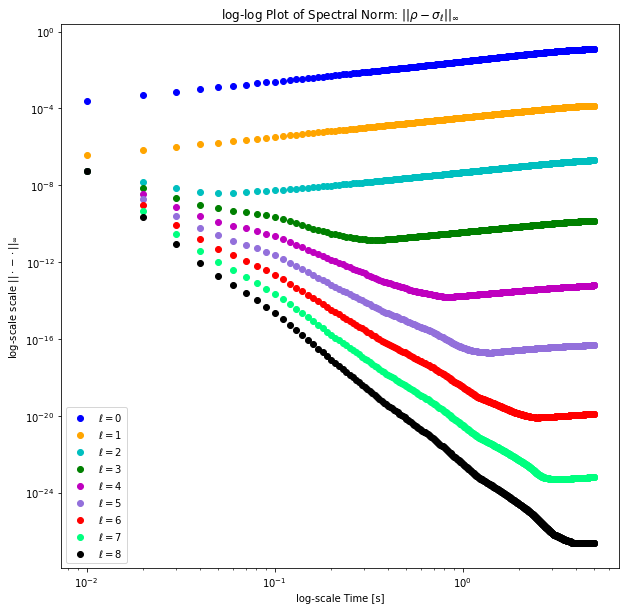

In [22]:
fig0, ax0 = plt.subplots(figsize=(10,10))

for n in range(len(rho_vs_all_sigmas)):
    plt.scatter(ts[:-1], rho_vs_all_sigmas[n], color = colours[n],label = r'$\ell = {%d}$' %n)

#plt.xlim(8e-2, 5e0)
ax0.legend(loc=0)
ax0.set_xlabel(r'log-scale Time [s]')
ax0.set_ylabel(r'log-scale scale $||\cdot - \cdot||_{\infty}$')
ax0.set_title(r'log-log Plot of Spectral Norm: $||\rho - \sigma_{\ell}||_{\infty}$')
plt.xscale('log')
plt.yscale('log')

In [24]:
Kexact = [-mat_ansys.logM(rho) for rho in rho_exact[1:]]
Kell0 = [-mat_ansys.logM(sigma) for sigma in sigmat0[1:]]
Kell1 = [-mat_ansys.logM(sigma) for sigma in sigmat1[1:]]
Kell2 = [-mat_ansys.logM(sigma) for sigma in sigmat2[1:]]
Kell3 = [-mat_ansys.logM(sigma) for sigma in sigmat3[1:]]
Kell4 = [-mat_ansys.logM(sigma) for sigma in sigmat4[1:]]
Kell5 = [-mat_ansys.logM(sigma) for sigma in sigmat5[1:]]
Kell6 = [-mat_ansys.logM(sigma) for sigma in sigmat6[1:]]
Kell7 = [-mat_ansys.logM(sigma) for sigma in sigmat7[1:]]
Kell8 = [-mat_ansys.logM(sigma) for sigma in sigmat8[1:]]

AssertionError: Non positive-defined input matrix

In [ ]:
Kex_vs_Kell0 = [np.linalg.norm(Kexact[t] - Kell0[t], np.inf) / t**0 for t in range(len(sigmat1))]
Kex_vs_Kell1 = [np.linalg.norm(Kexact[t] - Kell1[t], np.inf) / t**1 for t in range(len(sigmat1))]
Kex_vs_Kell2 = [np.linalg.norm(Kexact[t] - Kell2[t], np.inf) / t**2 for t in range(len(sigmat1))]
Kex_vs_Kell3 = [np.linalg.norm(Kexact[t] - Kell3[t], np.inf) / t**3 for t in range(len(sigmat1))]
Kex_vs_Kell4 = [np.linalg.norm(Kexact[t] - Kell4[t], np.inf) / t**4 for t in range(len(sigmat1))]
Kex_vs_Kell5 = [np.linalg.norm(Kexact[t] - Kell5[t], np.inf) / t**5 for t in range(len(sigmat1))]
Kex_vs_Kell6 = [np.linalg.norm(Kexact[t] - Kell6[t], np.inf) / t**6 for t in range(len(sigmat1))]
Kex_vs_Kell7 = [np.linalg.norm(Kexact[t] - Kell7[t], np.inf) / t**7 for t in range(len(sigmat1))]
Kex_vs_Kell8 = [np.linalg.norm(Kexact[t] - Kell8[t], np.inf) / t**8 for t in range(len(sigmat1))]
#rho_vs_sigma8 = [np.linalg.norm(rho_exact[t] - sigmat8[t]) for t in range(len(sigmat1))]
Kex_vs_all_Kell = [rho_vs_sigma0, rho_vs_sigma1, rho_vs_sigma2, rho_vs_sigma3, rho_vs_sigma4, rho_vs_sigma5, rho_vs_sigma6, rho_vs_sigma7, rho_vs_sigma8]#, rho_vs_sigma8]

In [ ]:
fig0, ax0 = plt.subplots(figsize=(10,10))

for n in range(len(rho_vs_all_sigmas)):
    plt.scatter(ts[:-1], Kex_vs_all_Kell[n], color = colours[n],label = r'$\ell = {%d}$' %n)

#plt.xlim(8e-2, 5e0)
ax0.legend(loc=0)
ax0.set_xlabel(r'log-scale Time [s]')
ax0.set_ylabel(r'log-scale scale $||\cdot - \cdot||_{\infty}$')
ax0.set_title(r'log-log Plot of Spectral Norm: $||{\bf K} - {\bf K}^{\ell}||_{\infty}$')
plt.xscale('log')
plt.yscale('log')

In [ ]:
avsg_xop_sq_exact = resultados["res_exact"]['res_exact_MaxEnt8'].expect[0][:-1]
avgs_xop_sq_HB0 = resultados["all_max_ent_evs"]["res_evs_MaxEnt0"]["Avgs"][0]
avgs_xop_sq_HB1 = resultados["all_max_ent_evs"]["res_evs_MaxEnt1"]["Avgs"][0]
avgs_xop_sq_HB2 = resultados["all_max_ent_evs"]["res_evs_MaxEnt2"]["Avgs"][0]
avgs_xop_sq_HB3 = resultados["all_max_ent_evs"]["res_evs_MaxEnt3"]["Avgs"][0]
avgs_xop_sq_HB4 = resultados["all_max_ent_evs"]["res_evs_MaxEnt4"]["Avgs"][0]
avgs_xop_sq_HB5 = resultados["all_max_ent_evs"]["res_evs_MaxEnt5"]["Avgs"][0]
avgs_xop_sq_HB6 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Avgs"][0]

avgs_xop_sq_HB7 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Avgs"][0]
avgs_xop_sq_HB8 = resultados["all_max_ent_evs"]["res_evs_MaxEnt6"]["Avgs"][0]

freq_fft = np.fft.fftfreq(ts.shape[-1])
freq_plot = freq_fft
freqs_fft_avgs_x_op_exact = np.fft.fft(avsg_xop_sq_exact)[1:]
freqs_fft_avgs_x_op_hb1 = np.fft.fft(avgs_xop_sq_HB1)[1:]
freqs_fft_avgs_x_op_hb3 = np.fft.fft(avgs_xop_sq_HB3)[1:]
freqs_fft_avgs_x_op_hb6 = np.fft.fft(avgs_xop_sq_HB6)[1:]
freqs_fft_avgs_x_op_hb8 = np.fft.fft(avgs_xop_sq_HB7)[1:]

freqs_fft_avgs_all = [freqs_fft_avgs_x_op_hb1, freqs_fft_avgs_x_op_hb3, freqs_fft_avgs_x_op_hb6, freqs_fft_avgs_x_op_hb8]

In [ ]:
HB_dims = [1,3,6,8]
Tot = 4; Cols = 1
Rows = Tot // Cols 
if Tot % Cols != 0:
    Rows += 1
Position = range(1,Tot + 1)
fig = plt.figure(figsize=(10, 10))
colors = ["orange", "green", "red", "magenta", "yellow"]

for k in range(Tot):
    if k == 1:
        ax.set_title(r'FFT Amplitude $\langle \hat{\bf x} \rangle_{\rho}$ vs. Amplitude $\langle \hat{\bf x} \rangle_{\sigma}$')  
    ax = fig.add_subplot(Rows, Cols, Position[k])
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_x_op_exact.real + 1j * freqs_fft_avgs_x_op_exact.imag), color = "blue", label = "Exact")
    ax.plot(freq_plot[1:][:-1], abs(freqs_fft_avgs_all[k].real + 1j * freqs_fft_avgs_all[k].imag), color = colors[k], label = "Rest. ME ℓ=" + str(HB_dims[k]))
    plt.ylabel(r'${\cal F} [\cdot](\omega)$')
    if k == 2: 
        plt.xlabel(r'$\omega$')
    plt.xlim(0, .004)
    ax.legend(loc=0)